In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


In [2]:
train_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
test_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')

Ingeniería de características

In [3]:
def n_nonprod(df):
    x = df.loc[(df['activity'] == 'Nonproduction')& (df['action_time']>0),
               ['id','event_id']].groupby('id').count().rename(
        columns = {'event_id':'n_nonprod'}).reset_index()
    return x

def len_nonprod(df):
    x = df.loc[df['activity'] == 'Nonproduction',['id','action_time']].groupby('id').sum().rename(
         columns = {'action_time':'len_nonprod'}).reset_index()
    return x

def n_input(df):
    x = df.loc[(df['activity'] == 'Input')& (df['action_time']>0),
               ['id','event_id']].groupby('id').count().rename(
        columns = {'event_id':'n_input'}).reset_index()
    return x

def len_input(df):
    x = df.loc[df['activity'] == 'Input',['id','action_time']].groupby('id').sum().rename(
         columns = {'action_time':'len_input'}).reset_index()
    return x

def n_replace(df):
    x = df.loc[(df['activity'] == 'Replace')& (df['action_time']>0),
               ['id','event_id']].groupby('id').count().rename(
        columns = {'event_id':'n_replace'}).reset_index()
    return x

def len_replace(df):
    x = df.loc[df['activity'] == 'Replace',['id','action_time']].groupby('id').sum().rename(
         columns = {'action_time':'len_replace'}).reset_index()
    return x

def n_remove(df):
    x = df.loc[(df['activity'] == 'Remove/Cut')& (df['action_time']>0),
               ['id','event_id']].groupby('id').count().rename(
        columns = {'event_id':'n_remove'}).reset_index()
    return x

def len_remove(df):
    x = df.loc[df['activity'] == 'Remove/Cut',['id','action_time']].groupby('id').sum().rename(
         columns = {'action_time':'len_remove'}).reset_index()
    return x

def n_words(df):
    x = df[['id','word_count']].groupby('id').last()
    return x

def act_time(df):
    x = df.groupby('id')['action_time'].sum().reset_index().rename(
        columns = {'action_time':'act_time'})
    return x
def writing_time(df):
    x = pd.DataFrame(df.groupby('id').last()['up_time']).reset_index().rename(columns={'up_time':'writing_time'})
    return x

def n_events(df):
    x = df[['id','event_id']].groupby('id').count().reset_index().rename(columns={'event_id':'n_events'})
    return x

#considerando [',','.',';',':'] la correl en lugar de ser 0.587 es de 0.58
def punct(df):
    x = df.loc[df.down_event.isin(['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']),['id','down_event']].groupby('id').count().rename(columns={'down_event':'punct'})
    return x

def cuenta_frases(df):
    x = df.loc[df.down_event == '.','id'].count()
    return x

def cuenta_punct(df):
    x = df.loc[df.down_event.isin(['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']),'id'].count()  
    return x
#varianza del proceso,dividir el tiempo de 5 a 10 intervalos y ver el num de frases producidas

def numfrases_intervalo(df):
    dic = []
    for nombre, datos in df.groupby('id'):
        dic.append(np.min([cuenta_frases(h) for h in np.array_split(datos,indices_or_sections = 2)]))
    x = pd.DataFrame({'id': df.id.unique(),'numfrases_intervalo':dic})
    return x   
def numpunct_intervalo(df):
    dic = []
    for nombre, datos in df.groupby('id'):
        dic.append(np.max([cuenta_punct(h) for h in np.array_split(datos,indices_or_sections = 5)]))
    x = pd.DataFrame({'id': df.id.unique(),'numpunct_intervalo':dic})
    return x


def cursor_position_mean(df):
    x = df[['id','cursor_position']].groupby('id').mean().rename(
         columns = {'cursor_position':'cursor_position_mean'}).reset_index()
    return x

def n_remove2(df):
    x = df.loc[df.down_event.isin(['Backspace','Delete']),['id','down_event']].groupby('id').count().rename(columns={'down_event':'n_remove2'})
    return x

def n_parrafos(df):
    x = df.loc[df.down_event=='Enter',['id','down_event']].groupby('id').count().rename(columns={'down_event':'n_parrafos'})
    return x
def n_dropenter(df):
    x = df.loc[(df['text_change'] == '\n') & (df['activity'] == 'Remove/Cut'),['id','text_change']].groupby('id').count().rename(columns={'text_change':'n_dropenter'}) 
    return x
def n_parrafos2(df):
    dataframe = train_scores.drop('score',axis=1).merge(n_parrafos(train_logs,on='id',how='left')).merge(n_dropenter,on='id',how='left').fillna(0) 
    x = dataframe['n_parrafos'] - dataframe['n_dropenter']
    return x
def doblenter(df):
    texto = train_logs.loc[train_logs.down_event=='Enter',['id','event_id','down_event']].groupby('id')
    dic = {'id':[],'num_parrafos':[]}
    for nombre, datos in texto:
        lista = [h for h in datos['event_id']]
        dic['id'].append(nombre)
        dic['num_parrafos'].append(np.sum([1 if ((h+1 in lista) and (h+2 not in lista)) else 0 for h in lista]))
    x = pd.DataFrame(dic)
    return x

def n_space(df):
    x = df.loc[df.down_event=='Space',['id','down_event']].groupby('id').count().rename(columns={'down_event':'n_space'})
    return x

def no_change(df):
    x = df.loc[df.text_change == 'NoChange',['id','text_change']].groupby('id').count().rename(columns = {'text_change':'num_nochange'})
    return x 

def num_shift(df):
    x = df.loc[df.down_event == 'Shift',['id','down_event']].groupby('id').count().rename(columns = {'down_event':'num_shift'})
    return x

In [4]:
def DatFeatures(df):
    dataframe = n_input(df)
    features = [len_input,n_nonprod,len_nonprod,n_remove,len_remove,
               n_replace,len_replace,n_events,n_words,
                act_time,writing_time,punct,numfrases_intervalo,cursor_position_mean,n_remove2,n_parrafos,n_space,n_dropenter,no_change,
               num_shift,doblenter,numpunct_intervalo]
    
    for fun in features:
        prev_dat = fun(df).fillna(0)
        dataframe = dataframe.merge(prev_dat,on='id',how='left').fillna(0)
    dataframe['pausa'] = dataframe['writing_time'] - dataframe['act_time']
    dataframe['time_by_word'] = (dataframe['writing_time']/dataframe['word_count']).replace([np.inf, np.inf],500000)
    dataframe['productivity'] = dataframe['act_time']/dataframe['writing_time']*100
    dataframe['n_caracteres2'] = dataframe['n_input'] - dataframe['n_remove2']
    dataframe['n_parrafos2'] = dataframe['n_parrafos'] - dataframe['n_dropenter']
    dataframe = dataframe.drop(['n_parrafos','n_dropenter'],axis=1)
    return dataframe

In [5]:
test_features = DatFeatures(test_logs)
train_features = DatFeatures(train_logs)

In [6]:
X_train = train_features.drop('id',axis=1)
X_test = test_features.drop('id',axis=1)

In [7]:
from scipy.stats import skew,boxcox
from sklearn.preprocessing import PowerTransformer,StandardScaler
transformer = PowerTransformer()
X_transformed = pd.DataFrame(transformer.fit_transform(X_train))
X_transformed.columns = X_train.columns
X_test_transformed = pd.DataFrame(transformer.transform(X_test))
X_test_transformed.columns = X_test.columns

In [8]:
y = train_scores['score']
y

0       3.5
1       3.5
2       6.0
3       2.0
4       4.0
       ... 
2466    3.5
2467    4.0
2468    1.5
2469    5.0
2470    4.0
Name: score, Length: 2471, dtype: float64

In [9]:
X_transformed.shape

(2471, 26)

In [9]:
import statsmodels.api as sm
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_aic = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_aic[new_column] = model.aic
        best_aic = new_aic.min()
        if best_aic < threshold_in:
            best_feature = new_aic.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with AIC {:.6}'.format(best_feature, best_aic))

        if not changed:
            break

    return included

In [16]:
forward_regression(X_transformed,y,threshold_in = 10000,verbose=True)

Add  n_caracteres2                  with AIC 5426.32
Add  punct                          with AIC 5338.42
Add  n_space                        with AIC 5266.14
Add  n_remove                       with AIC 5201.05
Add  numfrases_intervalo            with AIC 5166.06
Add  word_count                     with AIC 5120.52
Add  num_parrafos                   with AIC 5090.55
Add  len_replace                    with AIC 5075.29
Add  num_shift                      with AIC 5065.66
Add  n_remove2                      with AIC 5060.58
Add  n_input                        with AIC 5059.93
Add  n_events                       with AIC 5057.5
Add  n_parrafos2                    with AIC 5056.9
Add  n_replace                      with AIC 5056.64
Add  len_input                      with AIC 5056.23
Add  productivity                   with AIC 5053.1
Add  pausa                          with AIC 5049.29
Add  writing_time                   with AIC 5042.23
Add  time_by_word                   with AIC 5038

['n_caracteres2',
 'punct',
 'n_space',
 'n_remove',
 'numfrases_intervalo',
 'word_count',
 'num_parrafos',
 'len_replace',
 'num_shift',
 'n_remove2',
 'n_input',
 'n_events',
 'n_parrafos2',
 'n_replace',
 'len_input',
 'productivity',
 'pausa',
 'writing_time',
 'time_by_word',
 'act_time',
 'numpunct_intervalo',
 'len_nonprod',
 'n_nonprod',
 'len_remove',
 'num_nochange',
 'cursor_position_mean']

Decidimos quedarnos con un subgrupo de variables

In [9]:
X_new = X_transformed[['n_caracteres2','n_space','n_remove','n_input',
 'word_count',
 'len_replace',
 'punct',
 'len_input','numfrases_intervalo']]
X_new

,n_caracteres2,n_space,n_remove,n_input,word_count,len_replace,punct,len_input,numfrases_intervalo
0,-0.679641,-0.491288,0.398042,-0.499160,-0.783385,1.364617,-0.427875,-0.168139,0.047442
1,-0.553230,-0.274056,-0.187430,-0.585243,-0.211489,0.891012,0.171597,-0.216921,-0.596390
2,0.881413,0.528204,0.464733,0.815280,0.353707,1.302600,-0.034800,0.628867,-0.596390
3,-1.497497,-1.436329,-0.810476,-1.537138,-1.340658,1.031427,-1.476375,-0.879976,-0.838498
4,-0.954198,-0.725512,0.680902,-0.581592,-0.813783,-0.877390,0.564518,0.014805,0.047442
...,...,...,...,...,...,...,...,...,...
2466,0.515616,0.900359,1.557046,0.863461,-0.609333,1.089332,1.112608,1.068100,1.699201
2467,0.237780,0.041297,-1.721188,-0.086100,0.544592,0.935690,0.479424,-0.523280,0.604617
2468,0.608807,3.103108,-1.358890,0.300677,-1.406085,-0.877390,-2.569311,-0.419435,-3.061941
2469,0.507591,0.092937,-0.116070,0.359858,0.406010,-0.877390,0.673538,-0.010998,0.426509


**PCA**

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit(X_transformed)
pca.explained_variance_ratio_

array([4.95635005e-01, 1.14639203e-01, 7.26547782e-02, 7.11690602e-02,
       5.56459171e-02, 4.98947972e-02, 4.12742464e-02, 2.76646250e-02,
       2.05823391e-02, 1.40934104e-02, 1.08833769e-02, 6.91409808e-03,
       5.06961716e-03, 3.23128588e-03, 2.88196577e-03, 1.98217800e-03,
       1.55618617e-03, 1.32923684e-03, 9.40809169e-04, 6.02276538e-04,
       4.80571004e-04, 4.24387860e-04, 2.33195876e-04, 1.59802777e-04,
       3.65165427e-05, 2.11136056e-05])

Text(0, 0.5, 'Varianza explicada')

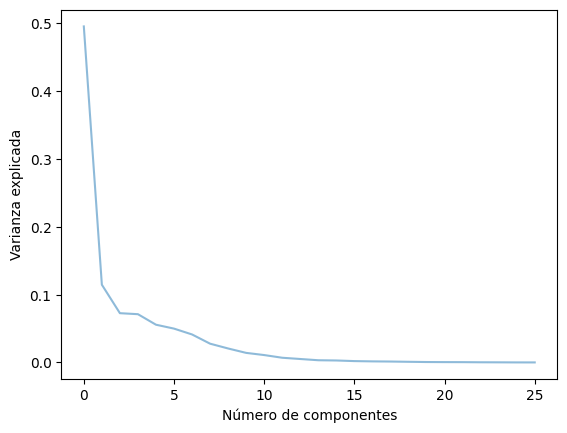

In [18]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows =1 ,ncols = 1)
ax.plot(range(0,len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.5)
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Varianza explicada')

In [19]:
4.95635005e-01+1.14639203e-01+ 7.26547782e-02+ 7.11690602e-02+5.56459171e-02

0.8097439635

In [17]:
pca1 = PCA(n_components=5)
principalComponents1 = pca1.fit(X_transformed)
pca1.explained_variance_ratio_
X_pca  = pd.DataFrame(pca1.transform(X_transformed),columns = ['PC1','PC2','PC3','PC4','PC5'])#pca.transform(X_transformed)
X_pca

,PC1,PC2,PC3,PC4,PC5
0,1.062409,2.058612,-0.704889,-0.690215,1.576003
1,0.877870,1.501165,-0.735476,0.044084,0.215036
2,-1.985381,1.718996,-1.218808,0.028675,0.359544
3,4.539848,-0.143656,-2.015783,-1.740455,1.181680
4,0.747422,-0.195317,1.046785,-1.509703,-0.721829
...,...,...,...,...,...
2466,-2.991957,0.725518,0.662536,-1.864612,2.266096
2467,0.714377,-0.630504,-1.584905,3.432563,-0.535787
2468,2.941707,0.213803,0.795411,1.239331,-0.465271
2469,-0.479700,-2.311065,-0.037105,-0.608224,0.244686


**Regresión lineal**

In [53]:
from sklearn.model_selection import RepeatedKFold,cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
cv = RepeatedKFold()
scores = []
datasets = [X_transformed,X_new,X_pca]
for i in datasets:
    sc = cross_validate(LinearRegression(), i, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores.append(-sc['test_score'].mean())
scores

[0.6777830751258037, 0.6814314136912505, 0.7192155375135987, 0.737487974830029]

In [54]:
resultados = pd.DataFrame({'Modelos' : ['Todas con transformación','Subgrupo con transformación',
                                        'Todas variables transformacion + pca'],
                          'RMSE Reg': scores})
resultados

,Modelos,RMSE Reg
0,Todas con transformación,0.677783
1,Subgrupo con transformación,0.681431
2,Todas variables transformacion + pca,0.719216
3,Subgrupo variables transformacion + pca,0.737488


Vemos si con regresión lasso(incluye "selección de características") la cosa mejora

In [55]:
from sklearn.linear_model import Lasso
scoresLasso = []
cv = KFold()
datasets = [X_transformed,X_new,X_pca]
for i in datasets:
    sc = cross_validate(Lasso(alpha=0.7), i, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scoresLasso.append(-sc['test_score'].mean())
scoresLasso

[1.0083657230255434,
 1.0083657230255434,
 0.7689454030534306,
 0.7890565462480947]

In [56]:
resultados = pd.DataFrame({'Modelos' : ['Todas con transformación','Subgrupo con transformación',
                                        'Todas variables transformacion + pca'],
                          'RMSE Reg': scoresLasso})
resultados

,Modelos,RMSE Reg
0,Todas con transformación,1.008366
1,Subgrupo con transformación,1.008366
2,Todas variables transformacion + pca,0.768945
3,Subgrupo variables transformacion + pca,0.789057


Veamos regresión ridge (bias variance trade-off)

In [57]:
from sklearn.linear_model import Ridge
scoresRidge= []
cv = RepeatedKFold()
datasets = [X_transformed,X_new,X_pca]
for i in datasets:
    sc = cross_validate(Ridge(alpha=0.7), i, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scoresRidge.append(-sc['test_score'].mean())
scoresRidge

[0.676509523693439, 0.681387275444493, 0.7193485562744938, 0.7373948961604693]

In [58]:
resultados = pd.DataFrame({'Modelos' : ['Todas con transformación','Subgrupo con transformación',
                                        'Todas variables transformacion + pca'],
                          'RMSE Reg': scoresRidge})
resultados

,Modelos,RMSE Reg
0,Todas con transformación,0.676510
1,Subgrupo con transformación,0.681387
2,Todas variables transformacion + pca,0.719349
3,Subgrupo variables transformacion + pca,0.737395


**Support Vector Regressor**

In [47]:
X_new = X_transformed[['n_caracteres2','n_space','n_remove','n_input',
 'word_count',
 'len_replace',
 'punct','numfrases_intervalo']]
X_new
#conjunto de variables forward_regression

,n_caracteres2,n_space,n_remove,n_input,word_count,len_replace,punct,numfrases_intervalo
0,-0.679641,-0.491288,0.398042,-0.499160,-0.783385,1.364617,-0.427875,0.047442
1,-0.553230,-0.274056,-0.187430,-0.585243,-0.211489,0.891012,0.171597,-0.596390
2,0.881413,0.528204,0.464733,0.815280,0.353707,1.302600,-0.034800,-0.596390
3,-1.497497,-1.436329,-0.810476,-1.537138,-1.340658,1.031427,-1.476375,-0.838498
4,-0.954198,-0.725512,0.680902,-0.581592,-0.813783,-0.877390,0.564518,0.047442
...,...,...,...,...,...,...,...,...
2466,0.515616,0.900359,1.557046,0.863461,-0.609333,1.089332,1.112608,1.699201
2467,0.237780,0.041297,-1.721188,-0.086100,0.544592,0.935690,0.479424,0.604617
2468,0.608807,3.103108,-1.358890,0.300677,-1.406085,-0.877390,-2.569311,-3.061941
2469,0.507591,0.092937,-0.116070,0.359858,0.406010,-0.877390,0.673538,0.426509


In [48]:
X_new1 = X_transformed[['n_caracteres2','n_space','n_input',
 'word_count',
 'n_events',
 'punct','time_by_word','cursor_position_mean','n_parrafos2','numfrases_intervalo']]
X_new1
#conjunto de variables random_forest

,n_caracteres2,n_space,n_input,word_count,n_events,punct,time_by_word,cursor_position_mean,n_parrafos2,numfrases_intervalo
0,-0.679641,-0.491288,-0.499160,-0.783385,-0.412654,-0.427875,0.825252,-0.770588,-0.629091,0.047442
1,-0.553230,-0.274056,-0.585243,-0.211489,-0.503278,0.171597,0.264062,-0.546303,-0.300186,-0.596390
2,0.881413,0.528204,0.815280,0.353707,0.653824,-0.034800,-0.302503,-0.697702,1.029939,-0.596390
3,-1.497497,-1.436329,-1.537138,-1.340658,-1.501620,-1.476375,0.738488,-1.477980,-1.507033,-0.838498
4,-0.954198,-0.725512,-0.581592,-0.813783,-0.435189,0.564518,0.659110,-1.212174,0.462143,0.047442
...,...,...,...,...,...,...,...,...,...,...
2466,0.515616,0.900359,0.863461,-0.609333,0.957832,1.112608,0.646564,-0.553560,-1.020353,1.699201
2467,0.237780,0.041297,-0.086100,0.544592,-0.372480,0.479424,-0.452539,0.145018,1.192038,0.604617
2468,0.608807,3.103108,0.300677,-1.406085,-0.013636,-2.569311,1.619646,0.749125,-0.015460,-3.061941
2469,0.507591,0.092937,0.359858,0.406010,0.112226,0.673538,-0.719275,0.523666,-0.629091,0.426509


In [51]:
from sklearn import svm
model = svm.SVR(kernel='rbf',epsilon=0.2777777777777778)
scores = []
datasets = [X_transformed,X_new,X_new1]
for i in datasets:
    sc = cross_validate(model, i, y, cv=cv,scoring=('neg_root_mean_squared_error'),return_train_score=True)
    scores.append(-sc['test_score'].mean())
scores

[0.6623129897617216, 0.6565891027701305, 0.6542558535719024]

In [52]:
resultados =pd.DataFrame({'Modelos' : ['Todas con transformación','Subgrupo con transformación forward_regresion',
                                        'Subgrupo con transformación importanciaRF'],
                          'RMSE SVR': scores})
resultados

,Modelos,RMSE SVR
0,Todas con transformación,0.662313
1,Subgrupo con transformación forward_regresion,0.656589
2,Subgrupo con transformación importanciaRF,0.654256


Importances RandomForest conjunto final

In [12]:
X_new = X_transformed[['n_caracteres2',
 'punct',
 'n_space',
 'n_remove',
 'numfrases_intervalo',
 'word_count',
 'num_parrafos',
 'len_replace',
 'num_shift',
 'n_remove2',
 'n_input',
 'n_events',
 'n_parrafos2']]#importances random forest

In [30]:
from sklearn.model_selection import KFold,cross_validate
cv = KFold()

In [31]:
from sklearn import svm
model2 = svm.SVR(kernel='rbf',epsilon=0.2777777777777778)
scores2 = []
datasets = [X_transformed,X_new]
for i in datasets:
    sc2 = cross_validate(model2, i, y, cv=cv,scoring=('neg_root_mean_squared_error'),return_train_score=True)
    scores2.append(-sc2['test_score'].mean())
scores2

[0.6652745360858208, 0.648216603773137]

In [32]:
resultados2 =pd.DataFrame({'Modelos' : ['Todas con transformación','Subgrupo con transformación'
                                       ],
                          'RMSE SVR': scores2})
resultados2

,Modelos,RMSE SVR
0,Todas con transformación,0.665275
1,Subgrupo con transformación,0.648217


In [35]:
from sklearn.model_selection import ParameterGrid
param_grid = ParameterGrid(
                {'C': np.linspace(0.1,1,num=10),
                 'epsilon': np.linspace(0,1,num=10) ,
                 'gamma':['scale','auto']
                 }
             )
resultados = {'params': [], 'rmse': []}

for params in param_grid:
    
    modelo = svm.SVR(kernel='rbf',** params
             )
    
    sc2 = cross_validate(modelo, X_new, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2=-sc2['test_score'].mean()
    resultados['params'].append(params)
    resultados['rmse'].append(scores2)
    print(f"Modelo: {params} , rmse: {scores2}✓")

Modelo: {'C': 0.1, 'epsilon': 0.0, 'gamma': 'scale'} , rmse: 0.6775220905875481✓
Modelo: {'C': 0.1, 'epsilon': 0.0, 'gamma': 'auto'} , rmse: 0.6775135040198287✓
Modelo: {'C': 0.1, 'epsilon': 0.1111111111111111, 'gamma': 'scale'} , rmse: 0.6770589218964789✓
Modelo: {'C': 0.1, 'epsilon': 0.1111111111111111, 'gamma': 'auto'} , rmse: 0.6770460015180446✓
Modelo: {'C': 0.1, 'epsilon': 0.2222222222222222, 'gamma': 'scale'} , rmse: 0.6775864323173948✓
Modelo: {'C': 0.1, 'epsilon': 0.2222222222222222, 'gamma': 'auto'} , rmse: 0.6775701081744445✓
Modelo: {'C': 0.1, 'epsilon': 0.3333333333333333, 'gamma': 'scale'} , rmse: 0.6792938017338754✓
Modelo: {'C': 0.1, 'epsilon': 0.3333333333333333, 'gamma': 'auto'} , rmse: 0.6793038727701338✓
Modelo: {'C': 0.1, 'epsilon': 0.4444444444444444, 'gamma': 'scale'} , rmse: 0.6812822363367489✓
Modelo: {'C': 0.1, 'epsilon': 0.4444444444444444, 'gamma': 'auto'} , rmse: 0.6812745693926394✓
Modelo: {'C': 0.1, 'epsilon': 0.5555555555555556, 'gamma': 'scale'} , rmse:

In [36]:
min(resultados['rmse'])#0.6478134835843927 pruebo este modelo:

0.6478134835843927

**KNeighbors Regressor**

In [21]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.neighbors import KNeighborsRegressor
cv = KFold()
scores = []
for i in  range(1,25):
    model = KNeighborsRegressor(n_neighbors=i)
    sc = cross_validate(model, X_transformed, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores.append(round(-sc['test_score'].mean(),4))

Text(0.5, 0, 'RMSE Knn')

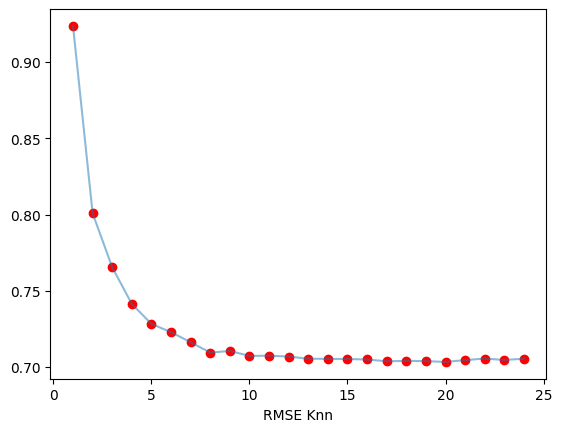

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(1,25), scores, alpha=0.5)
plt.scatter(range(1,25), scores, color="red")
plt.xlabel('RMSE Knn')

In [23]:
model3 = KNeighborsRegressor(n_neighbors=20)
scores3 = []
datasets = [X_transformed,X_new,X_pca,X_new_pca]
for i in datasets:
    sc3 = cross_validate(model3, i, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores3.append(-sc3['test_score'].mean())
scores3

[0.7033668790165084,
 0.6983938328828089,
 0.7257324268612366,
 0.7390233248330214]

In [24]:
resultados3 = pd.DataFrame({'Modelos' : ['Todas con transformación','Subgrupo con transformación',
                                        'Todas variables transformacion + pca','Subgrupo variables transformacion + pca'],
                          'RMSE Knn': scores3})
resultados3

,Modelos,RMSE Knn
0,Todas con transformación,0.703367
1,Subgrupo con transformación,0.698394
2,Todas variables transformacion + pca,0.725732
3,Subgrupo variables transformacion + pca,0.739023


In [20]:
from sklearn.model_selection import ParameterGrid
cv = KFold()
param_grid = ParameterGrid(
                {'n_neighbors': range(5,40),
                 'weights' : ['uniform','distance'],
                 'p':[1,2]
                 }
             )
resultados = {'params': [], 'rmse': []}

for params in param_grid:
    
    modelo = KNeighborsRegressor(** params
             )
    
    sc2 = cross_validate(modelo, X_new, y, cv=cv,scoring=('neg_root_mean_squared_error'))
    scores2=-sc2['test_score'].mean()
    resultados['params'].append(params)
    resultados['rmse'].append(scores2)
    print(f"Modelo: {params} , rmse: {scores2}✓")

Modelo: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'} , rmse: 0.7258786334352758✓
Modelo: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'} , rmse: 0.7259821943481418✓
Modelo: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} , rmse: 0.7226576081521123✓
Modelo: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'} , rmse: 0.7218899570739217✓
Modelo: {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'} , rmse: 0.7180526539573541✓
Modelo: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'} , rmse: 0.7175989963208445✓
Modelo: {'n_neighbors': 6, 'p': 2, 'weights': 'uniform'} , rmse: 0.7166273256701221✓
Modelo: {'n_neighbors': 6, 'p': 2, 'weights': 'distance'} , rmse: 0.715033003518683✓
Modelo: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'} , rmse: 0.7125837674566553✓
Modelo: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'} , rmse: 0.7118046975435809✓
Modelo: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'} , rmse: 0.7128315752742596✓
Modelo: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'} , r

In [30]:
min(resultados['rmse'])

0.6938448671025378